<a href="https://colab.research.google.com/github/nataliasbsg/Red-de-clasificacion-de-animales/blob/main/TFM_test1.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_datasets as tensorflow_datasets
import tensorflow_hub as hub
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_train = '../content/drive/MyDrive/Colab Notebooks/BD_LINCE_JABALI_CIERVO/Database' # path to directory with the images
# Orenar las categorias alfabéticamente
# categories = ['Ciervo', 'Conejo', 'Gato montes', 'Jabali', 'Jineta', 'Lince iberico', 'Zorro'] # categories that we can find in the directory
categories = sorted(os.listdir(dir_train))
categories_folders = [os.path.join(dir_train, categorie) for categorie in categories]
# carpeta_ciervo = os.path.join(dir_train, categories[0])
# carpeta_gato = os.path.join(dir_train, categories[1])
# carpeta_jabali = os.path.join(dir_train, categories[2])
# carpeta_lince = os.path.join(dir_train, categories[3])


print(categories)

['Ciervo', 'Conejo', 'Gato montes', 'Gineta', 'Jabali', 'Lince iberico', 'Oso', 'Zorro']


In [4]:
num_images = []

for categorie in categories:
  try:
    num_images.append(len(os.listdir('/content/drive/MyDrive/Colab Notebooks/BD_LINCE_JABALI_CIERVO/Database/{}'.format(categorie))))
    os.makedirs("dataset/{}".format(categorie))
    os.makedirs("test/{}".format(categorie))
  except:
    pass
limit_image = min(num_images)
print(num_images)
print(limit_image)

[1976, 1867, 2216, 1828, 1879, 1928, 1811, 2662]
1811


In [5]:
# Se limita el numero de imagenes para equilibrar las clases
for i, categorie in enumerate(categories):
  carpeta_fuente = categories_folders[i]# carpeta_ciervo
  carpeta_destino = '/content/dataset/{}'.format(categorie)
  carpeta_test = '/content/test/{}'.format(categorie)

  imagenes = [img for i, img in enumerate(os.listdir(carpeta_fuente)) if i<limit_image]
  imagenes, img_test = train_test_split(imagenes, test_size = 0.01, shuffle = True)
  print(len(img_test))
  for nombreimg in imagenes:
    # if i < 1879:
      #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

  for nombreimg in img_test:
    # if i < 1879:
      #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_test + '/' + nombreimg)

19
19
19
19
19
19
19
19


Found 11463 images belonging to 8 classes.
Found 2863 images belonging to 8 classes.


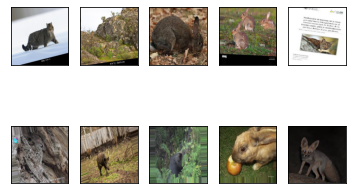

In [6]:
#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 20,
    width_shift_range = 0.07,
    height_shift_range = 0.07,
    shear_range = 2.5,
    zoom_range = [0.7, 1.3],
    validation_split = 0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()


In [7]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [8]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [9]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(len(categories), activation='softmax')
])

In [10]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
#Compilar modelo
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
EPOCAS = 20

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/20
359/359 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.8356

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


359/359 [==============================] - 300s 795ms/step - loss: 0.5149 - accuracy: 0.8356 - val_loss: 0.3666 - val_accuracy: 0.8788
Epoch 2/20
359/359 [==============================] - 276s 770ms/step - loss: 0.2780 - accuracy: 0.9083 - val_loss: 0.3493 - val_accuracy: 0.8872
Epoch 3/20
359/359 [==============================] - 276s 770ms/step - loss: 0.2417 - accuracy: 0.9201 - val_loss: 0.3248 - val_accuracy: 0.8907
Epoch 4/20
359/359 [==============================] - 275s 765ms/step - loss: 0.2238 - accuracy: 0.9261 - val_loss: 0.3763 - val_accuracy: 0.8697
Epoch 5/20
359/359 [==============================] - 275s 766ms/step - loss: 0.2090 - accuracy: 0.9322 - val_loss: 0.3445 - val_accuracy: 0.8854
Epoch 6/20
359/359 [==============================] - 277s 773ms/step - loss: 0.1930 - accuracy: 0.9369 - val_loss: 0.3438 - val_accuracy: 0.8882
Epoch 7/20
359/359 [==============================] - 277s 772ms/step - loss: 0.2009 - accuracy: 0.9323 - val_loss: 0.3385 - val_accura

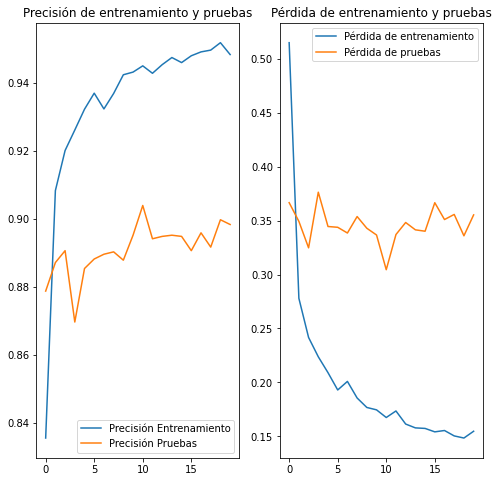

In [13]:
#Mostrar resultados con graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(EPOCAS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [14]:
#Categorizar una imagen de internet
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)


In [15]:
#0 = ciervo, 1 = jabali, 2 = lince
url = 'https://wwfes.awsassets.panda.org/img/original/cachorros_de_odrina_16__antonio_liebana.jpg' #debe ser 2
prediccion = categorizar (url)
print(prediccion)

5


In [16]:
#0 = ciervo, 1 = jabali, 2 = lince
url2 = 'https://img.freepik.com/foto-gratis/ciervo-rojo-habitat-natural-rutina-ciervos-fauna-europea_475641-941.jpg?size=626&ext=jpg&ga=GA1.2.1518270500.1634256000' #debe ser 0
prediccion = categorizar (url2)
print(prediccion)

0


In [17]:
#Crear la carpeta para exportarla a TF Serving
# !mkdir -p carpeta_salida/modelo_animales/1

In [18]:
# print(modelo.predict(imagen_prueba))

# New Section

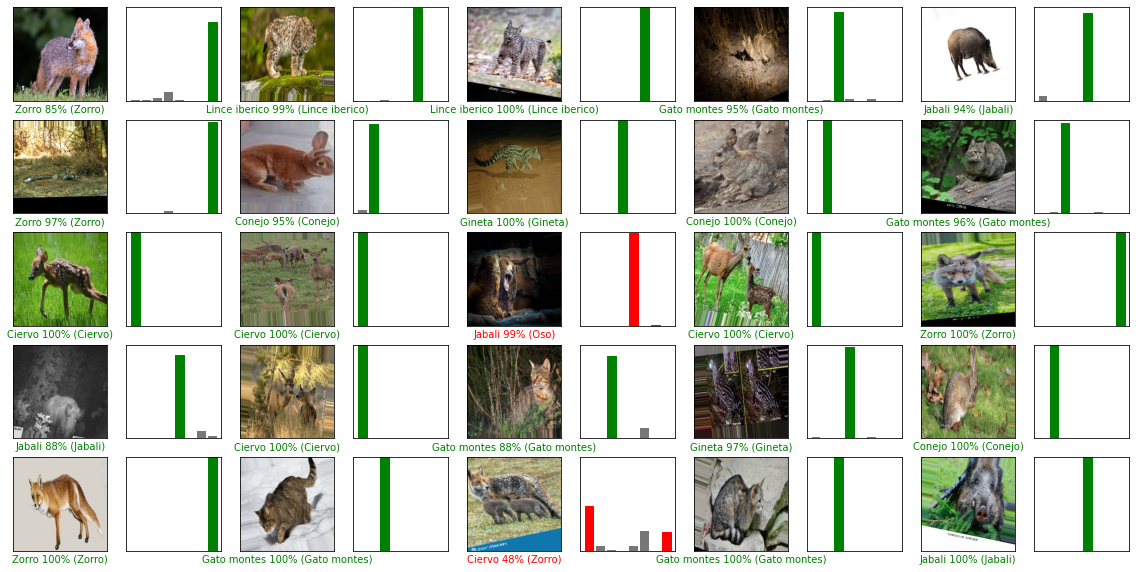

In [19]:
#Pintar 25 imagenes con predicciones, y marcar si son correctas (verde) o incorrectas (roja)
predicciones_prueba = []
imagenes_prueba= []
etiquetas_prueba= []
color = []

for imagen_prueba, etiqueta_prueba in data_gen_pruebas:
  for i in range(25):
      imagen_prueba[i] = np.array(imagen_prueba[i]).astype(float)
      imagenes_prueba.append (imagen_prueba[i])
      etiquetas_prueba.append (etiqueta_prueba[i])
      predicciones_prueba.append(modelo.predict(imagenes_prueba[i].reshape(-1, 224, 224, 3)))
      etiqueta_prediccion = int(np.argmax(predicciones_prueba[i], axis=-1))
      etiqueta_real = np.argmax(etiqueta_prueba[i])
      if etiqueta_prediccion == etiqueta_real: 
        color.append ('green')
      else:
        color.append ('red')
  break
  plt.show()

  
def graficar_imagen(i, predicciones_prueba, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = predicciones_prueba[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  etiqueta_prediccion = int(np.argmax(predicciones_prueba[i], axis=-1))
  etiqueta_real = np.argmax(etiqueta_real)

  plt.xlabel("{} {:2.0f}% ({})".format(categories[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                categories[etiqueta_real]),
                                color=color[i])
  
def graficar_valor_arreglo(i, predicciones_prueba, etiqueta_real):
  arr_predicciones, etiqueta_real = predicciones_prueba[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(len(categories)), arr_predicciones[0], color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_real = np.argmax(etiqueta_real)
  etiqueta_prediccion = int(np.argmax(arr_predicciones[0], axis=-1))
  grafica[etiqueta_real].set_color(color[i])
  grafica[etiqueta_prediccion].set_color(color[i])
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones_prueba, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones_prueba, etiquetas_prueba)

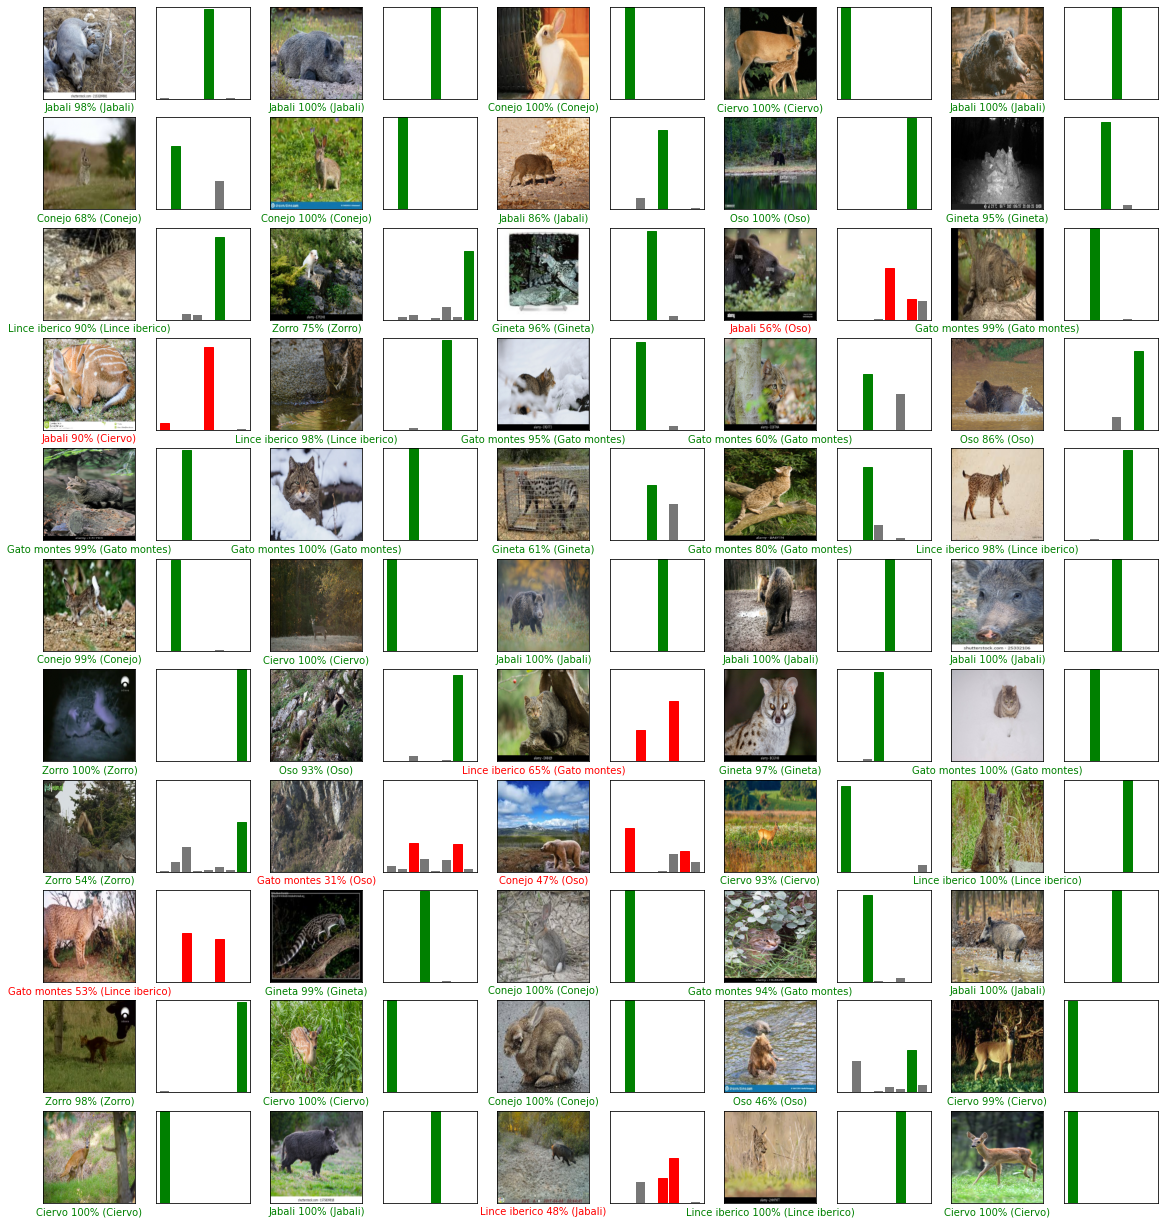

In [20]:
# Pintar imagenes de las carpetas test/{}.format(categorie)
#Pintar 25 imagenes con predicciones, y marcar si son correctas (verde) o incorrectas (roja)
predicciones_prueba = []
imagenes_prueba= []
etiquetas_prueba= []
color = []

filas = 11
columnas = 5
num_imagenes = filas*columnas

# data_test = [['ruta_a_imagen','etiqueta']] # estructura
data_test = []
for categorie in categories:
  for _img in  os.listdir("/content/test/{}".format(categorie)):
    _img_read = cv2.imread("/content/test/{}/{}".format(categorie, _img))
    # Pruebas:
    # 1- a quitar resize y reshape
    # 2- jugar con resize y reshape hasta encontrar el fallo
    # _img_read.resize(150528)
    # _img_read.reshape(224,224,3)
    
    _img_read = np.array(_img_read).astype(float)/255
    _img_read = cv2.resize(_img_read, (224,224))
    etiqueta_aux = np.zeros(len(categories))
    etiqueta_aux[categories.index(categorie)] = 1
    data_test.append([_img_read, etiqueta_aux])

random.shuffle(data_test)

for i, img in enumerate(data_test):
  imagen_prueba, etiqueta_prueba = img
  imagen_prueba = np.array(imagen_prueba).astype(float)
  imagenes_prueba.append (imagen_prueba)
  etiquetas_prueba.append (etiqueta_prueba)
  predicciones_prueba.append(modelo.predict(imagenes_prueba[len(imagenes_prueba)-1].reshape(-1, 224, 224, 3)))
  etiqueta_prediccion = int(np.argmax(predicciones_prueba[len(predicciones_prueba)-1], axis=-1))
  # print('prediccion',etiqueta_prediccion)
  etiqueta_real = np.argmax(etiqueta_prueba)
  # print('real',etiqueta_real)
  if etiqueta_prediccion == etiqueta_real: 
    color.append ('green')
  else:
    color.append ('red')
  if i>=num_imagenes-1:
    break

# plt.show()

  
def graficar_imagen(i, predicciones_prueba, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = predicciones_prueba[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  # print(img)
  img_2 = img[:,:,[2,1,0]]
  plt.imshow(img_2)
  etiqueta_prediccion = int(np.argmax(predicciones_prueba[i], axis=-1))
  etiqueta_real = np.argmax(etiqueta_real)

  plt.xlabel("{} {:2.0f}% ({})".format(categories[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                categories[etiqueta_real]),
                                color=color[i])
  
def graficar_valor_arreglo(i, predicciones_prueba, etiqueta_real):
  arr_predicciones, etiqueta_real = predicciones_prueba[i], etiqueta_real[i]
  
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(len(categories)), arr_predicciones[0], color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_real = np.argmax(etiqueta_real)
  # print(etiqueta_real)
  etiqueta_prediccion = int(np.argmax(arr_predicciones[0], axis=-1))
  # print(etiqueta_prediccion)
  grafica[etiqueta_real].set_color(color[i])
  grafica[etiqueta_prediccion].set_color(color[i])
  
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones_prueba, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones_prueba, etiquetas_prueba)

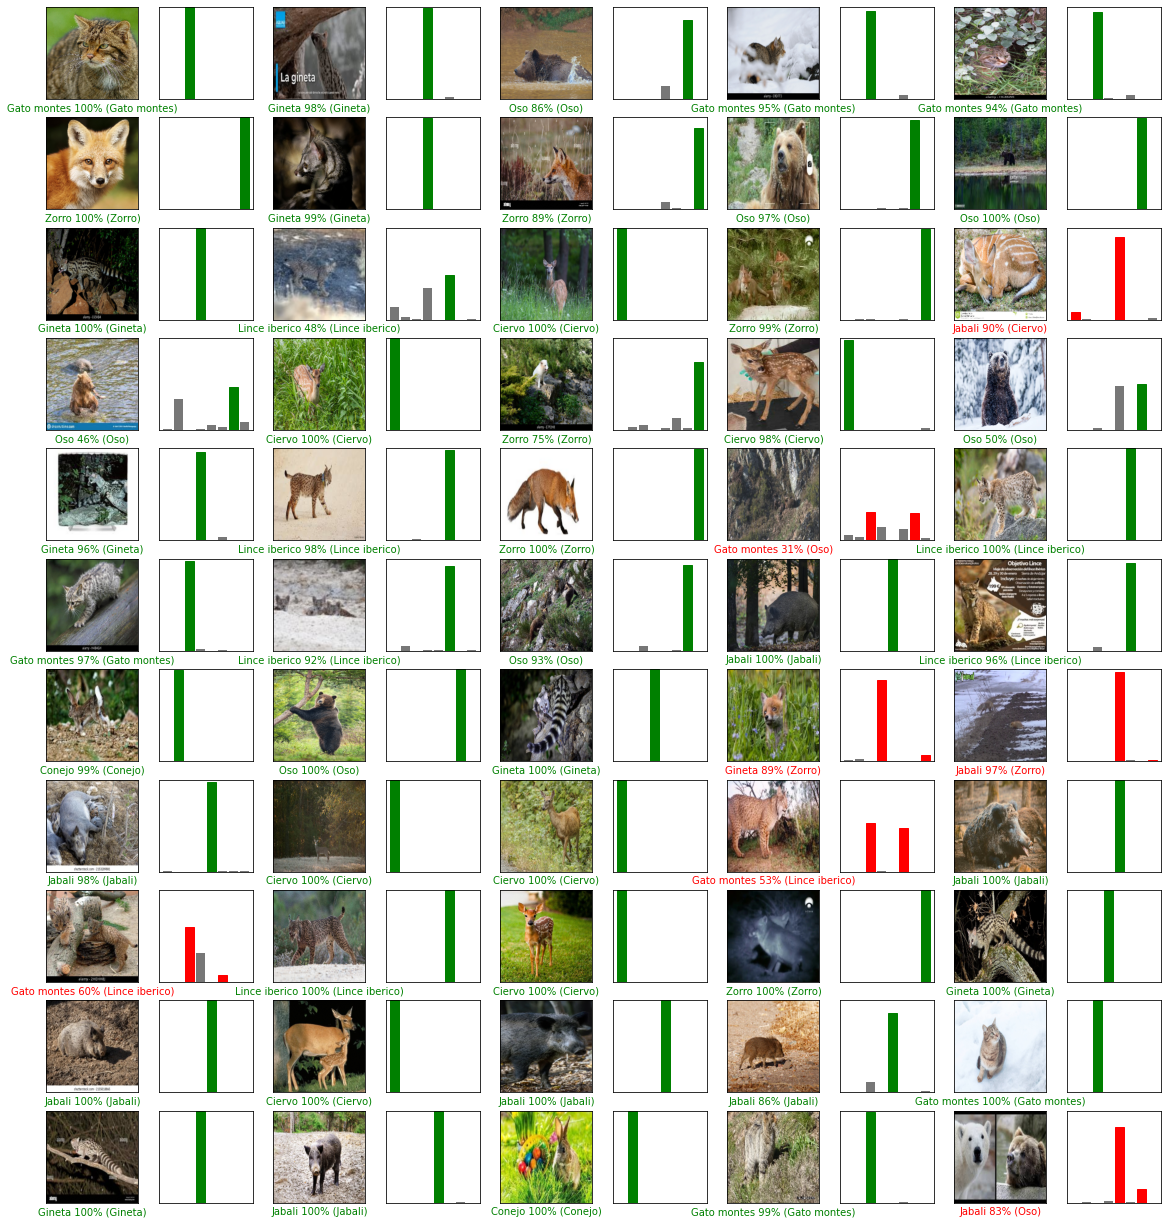

In [21]:
# Pintar imagenes de las carpetas test/{}.format(categorie)
#Pintar 25 imagenes con predicciones, y marcar si son correctas (verde) o incorrectas (roja)
predicciones_prueba = []
imagenes_prueba= []
etiquetas_prueba= []
color = []

filas = 11
columnas = 5
num_imagenes = filas*columnas

# data_test = [['ruta_a_imagen','etiqueta']] # estructura
data_test = []
for categorie in categories:
  for _img in  os.listdir("/content/test/{}".format(categorie)):
    _img_read = cv2.imread("/content/test/{}/{}".format(categorie, _img))
    # Pruebas:
    # 1- a quitar resize y reshape
    # 2- jugar con resize y reshape hasta encontrar el fallo
    # _img_read.resize(150528)
    # _img_read.reshape(224,224,3)
    
    _img_read = np.array(_img_read).astype(float)/255
    _img_read = cv2.resize(_img_read, (224,224))
    etiqueta_aux = np.zeros(len(categories))
    etiqueta_aux[categories.index(categorie)] = 1
    data_test.append([_img_read, etiqueta_aux])

random.shuffle(data_test)

for i, img in enumerate(data_test):
  imagen_prueba, etiqueta_prueba = img
  imagen_prueba = np.array(imagen_prueba).astype(float)
  imagenes_prueba.append (imagen_prueba)
  etiquetas_prueba.append (etiqueta_prueba)
  predicciones_prueba.append(modelo.predict(imagenes_prueba[len(imagenes_prueba)-1].reshape(-1, 224, 224, 3)))
  etiqueta_prediccion = int(np.argmax(predicciones_prueba[len(predicciones_prueba)-1], axis=-1))
  # print('prediccion',etiqueta_prediccion)
  etiqueta_real = np.argmax(etiqueta_prueba)
  # print('real',etiqueta_real)
  if etiqueta_prediccion == etiqueta_real: 
    color.append ('green')
  else:
    color.append ('red')
  if i>=num_imagenes-1:
    break

# plt.show()

  
def graficar_imagen(i, predicciones_prueba, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = predicciones_prueba[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  # print(img)
  img_2 = img[:,:,[2,1,0]]
  plt.imshow(img_2)
  etiqueta_prediccion = int(np.argmax(predicciones_prueba[i], axis=-1))
  etiqueta_real = np.argmax(etiqueta_real)

  plt.xlabel("{} {:2.0f}% ({})".format(categories[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                categories[etiqueta_real]),
                                color=color[i])
  
def graficar_valor_arreglo(i, predicciones_prueba, etiqueta_real):
  arr_predicciones, etiqueta_real = predicciones_prueba[i], etiqueta_real[i]
  
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(len(categories)), arr_predicciones[0], color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_real = np.argmax(etiqueta_real)
  # print(etiqueta_real)
  etiqueta_prediccion = int(np.argmax(arr_predicciones[0], axis=-1))
  # print(etiqueta_prediccion)
  grafica[etiqueta_real].set_color(color[i])
  grafica[etiqueta_prediccion].set_color(color[i])
  
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones_prueba, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones_prueba, etiquetas_prueba)